In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os

    Sample #  MLII  V5      Time Type  Sub  Chan  Num  Aux
18        18   NaN NaN  0:00.050    +  0.0   0.0  0.0   (N
19        19   NaN NaN       NaN  NaN  NaN   NaN  NaN  NaN
20        20   NaN NaN       NaN  NaN  NaN   NaN  NaN  NaN
21        21   NaN NaN       NaN  NaN  NaN   NaN  NaN  NaN
22        22   NaN NaN       NaN  NaN  NaN   NaN  NaN  NaN
(649982, 9)


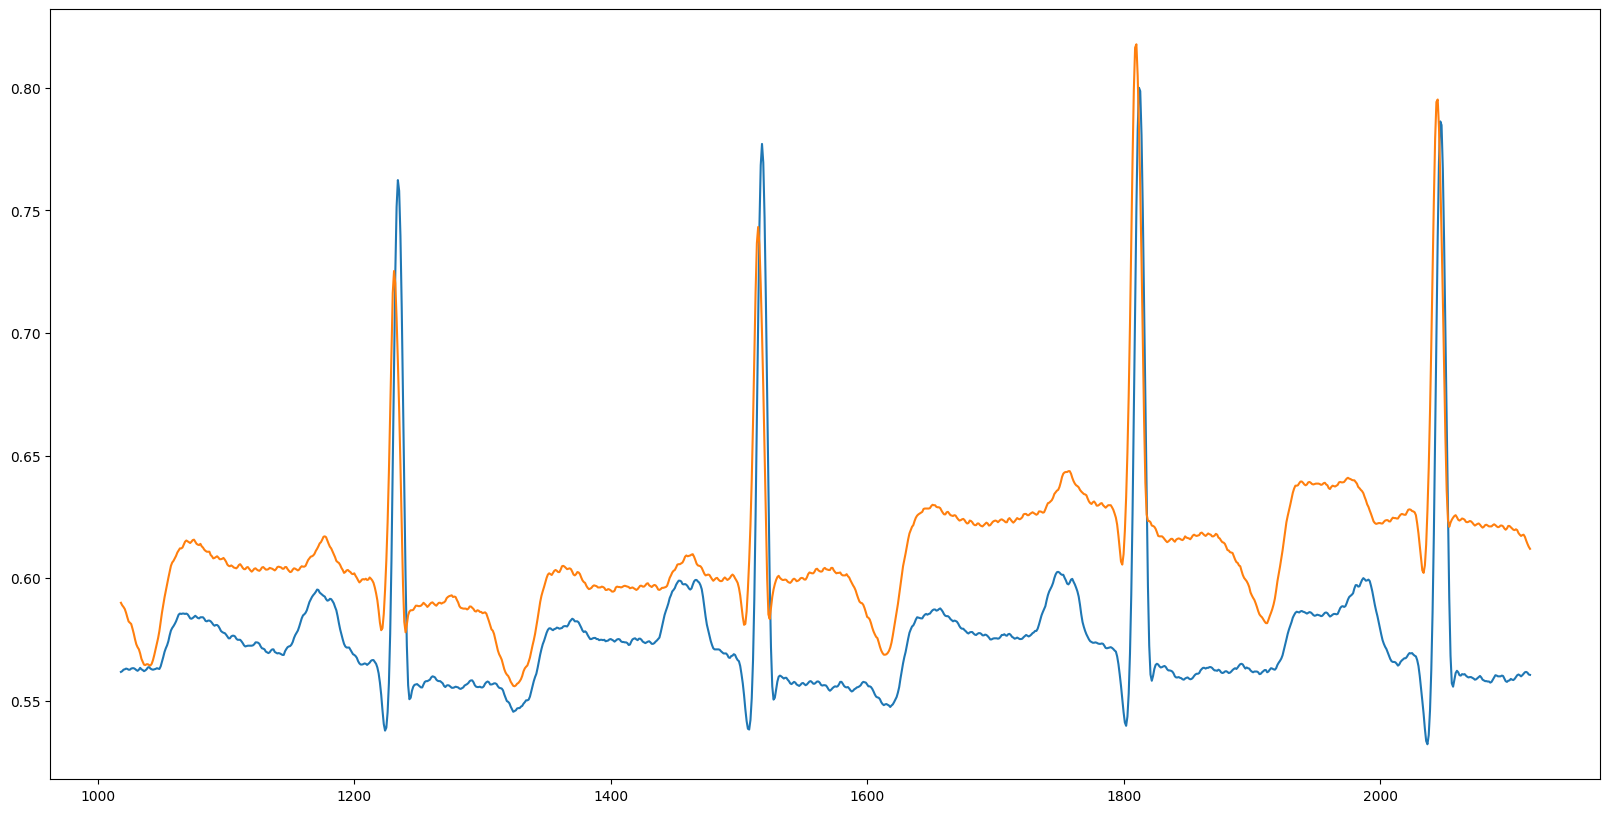

In [16]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')

# Find the first row where AUX is not NaN
index_first_non_nan = df["Aux"].first_valid_index()
if index_first_non_nan is not None:
    df = df.loc[index_first_non_nan:]

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8).mean()
df['V5'] = df['V5'].rolling(window=8).mean()

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

print(df.head())
print(df.shape)

In [20]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

    Sample #    MLII      V5 Patient  V1  V2  V4      Time Type  Sub  Chan  \
0          0   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
1          1   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
2          2   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
3          3   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
4          4   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
5          5   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
6          6   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
7          7   995.0  1011.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
8          8  1000.0  1008.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
9          9   997.0  1008.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
10        10   995.0  1007.0     100 NaN NaN NaN       NaN  NaN  NaN   NaN   
11        11   994.0  1007.0     100 NaN NaN NaN       NaN  NaN 

In [40]:
#def first_non_nan_index(series):
#    first_non_nan = series.first_valid_index()
#    if first_non_nan is not None:
#        return series.index.get_loc(first_non_nan)
#    return -1

filtered_data = pd.DataFrame()

# Iterate through each unique patient
for patient_id, group in df.groupby('Patient'):
    # Find the first row where AUX is not NaN
    index_first_non_nan = group['Aux'].first_valid_index()
    if index_first_non_nan is not None:
        filtered_data = pd.concat([filtered_data, group.loc[index_first_non_nan:]], ignore_index=True)

# Based on the time of the annotations, fill the NaN values with the next annotation for the Type column
df['Type'] = df['Type'].fillna(method='ffill')

18
650007
1300068
1950021
2600036
3250067
3900229
4550047
5200023
5850018
6500031
7150015
7800022
8450021
9100044
9750174
10400072
11050013
11700032
12350036
13000017
13650025
14300100
14950067
15600060
16250183
16900014
17550015
18200009
18850009
19500084
20150013
20800125
21450018
22100019
22750041
23400102
24050188
24700000
25350028
26000017
26650096
27300027
27950030
28600057
29250076
29900003
30550052
    Sample #   MLII      V5 Patient  V1  V2  V4      Time Type  Sub  Chan  \
0         18  990.0  1014.0     100 NaN NaN NaN  0:00.050    +  0.0   0.0   
1         19  993.0  1016.0     100 NaN NaN NaN       NaN    +  NaN   NaN   
2         20  989.0  1016.0     100 NaN NaN NaN       NaN    +  NaN   NaN   
3         21  988.0  1013.0     100 NaN NaN NaN       NaN    +  NaN   NaN   
4         22  986.0  1009.0     100 NaN NaN NaN       NaN    +  NaN   NaN   
5         23  988.0  1008.0     100 NaN NaN NaN       NaN    +  NaN   NaN   
6         24  993.0  1007.0     100 NaN NaN NaN    

Sample #    31200000
MLII        29900000
V5           3250000
Patient     31200000
V1          26000000
V2           2600000
V4            650000
Time          112647
Type          112647
Sub           112647
Chan          112647
Num           112647
Aux             1728
dtype: int64


<BarContainer object of 13 artists>

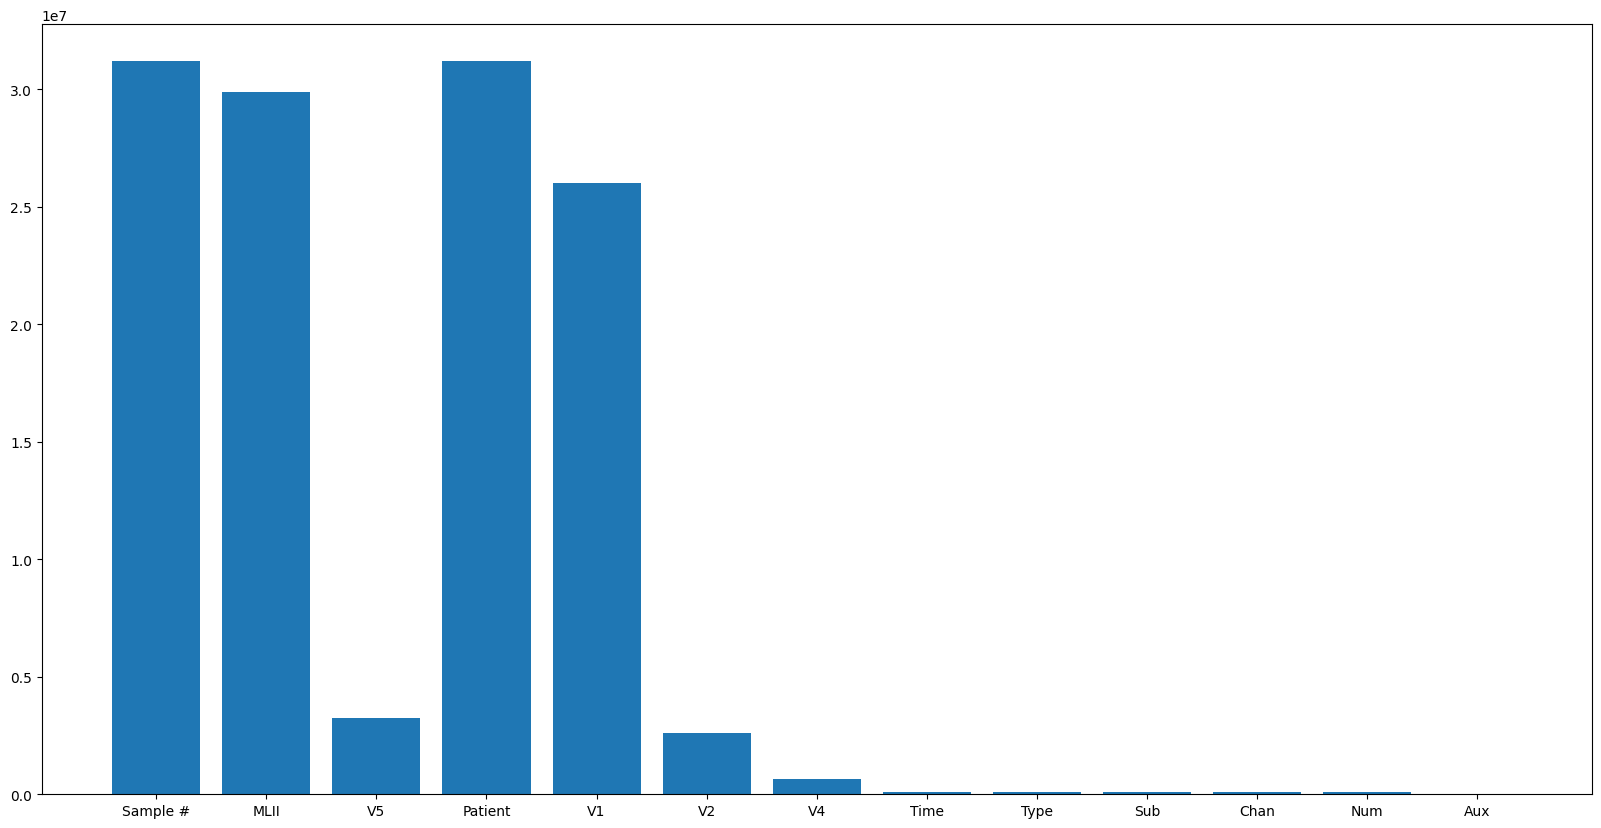

In [27]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [28]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
MLII        float64
V5          float64
Patient      object
V1          float64
V2          float64
V4          float64
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [29]:
# Print the number of samples that are missing MLII
print('Samples missing MLII:', df['MLII'].isnull().sum())

# Print the number of samples that are missing V1, V2, V4 or V5 all at the same time
print('Samples missing V1, V2, V4 or V5 alltogther:', df[['V1', 'V2', 'V4', 'V5']].isnull().all(axis=1).sum())

Samples missing MLII: 1300000
Samples missing V1, V2, V4 or V5 alltogther: 0


In [30]:
df.describe()

,Sample #,MLII,V5,V1,V2,V4,Sub,Chan,Num
count,3.120000e+07,2.990000e+07,3.250000e+06,2.600000e+07,2.600000e+06,650000.000000,112647.000000,112647.0,112647.0
mean,3.249995e+05,9.563606e+02,9.712235e+02,1.004138e+03,1.005862e+03,913.617809,0.062620,0.0,0.0
std,1.876388e+05,9.706090e+01,4.559114e+01,8.301823e+01,1.459426e+02,52.292792,0.406984,0.0,0.0
min,0.000000e+00,0.000000e+00,5.310000e+02,0.000000e+00,0.000000e+00,372.000000,-1.000000,0.0,0.0
25%,1.624998e+05,9.030000e+02,9.470000e+02,9.590000e+02,9.430000e+02,889.000000,0.000000,0.0,0.0
50%,3.249995e+05,9.640000e+02,9.730000e+02,1.023000e+03,1.021000e+03,912.000000,0.000000,0.0,0.0
75%,4.874992e+05,9.970000e+02,9.930000e+02,1.049000e+03,1.050000e+03,936.000000,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,1.419000e+03,2.047000e+03,2.047000e+03,1516.000000,9.000000,0.0,0.0


array([[<AxesSubplot: title={'center': 'Sample #'}>,
        <AxesSubplot: title={'center': 'MLII'}>,
        <AxesSubplot: title={'center': 'V5'}>],
       [<AxesSubplot: title={'center': 'V1'}>,
        <AxesSubplot: title={'center': 'V2'}>,
        <AxesSubplot: title={'center': 'V4'}>],
       [<AxesSubplot: title={'center': 'Sub'}>,
        <AxesSubplot: title={'center': 'Chan'}>,
        <AxesSubplot: title={'center': 'Num'}>]], dtype=object)

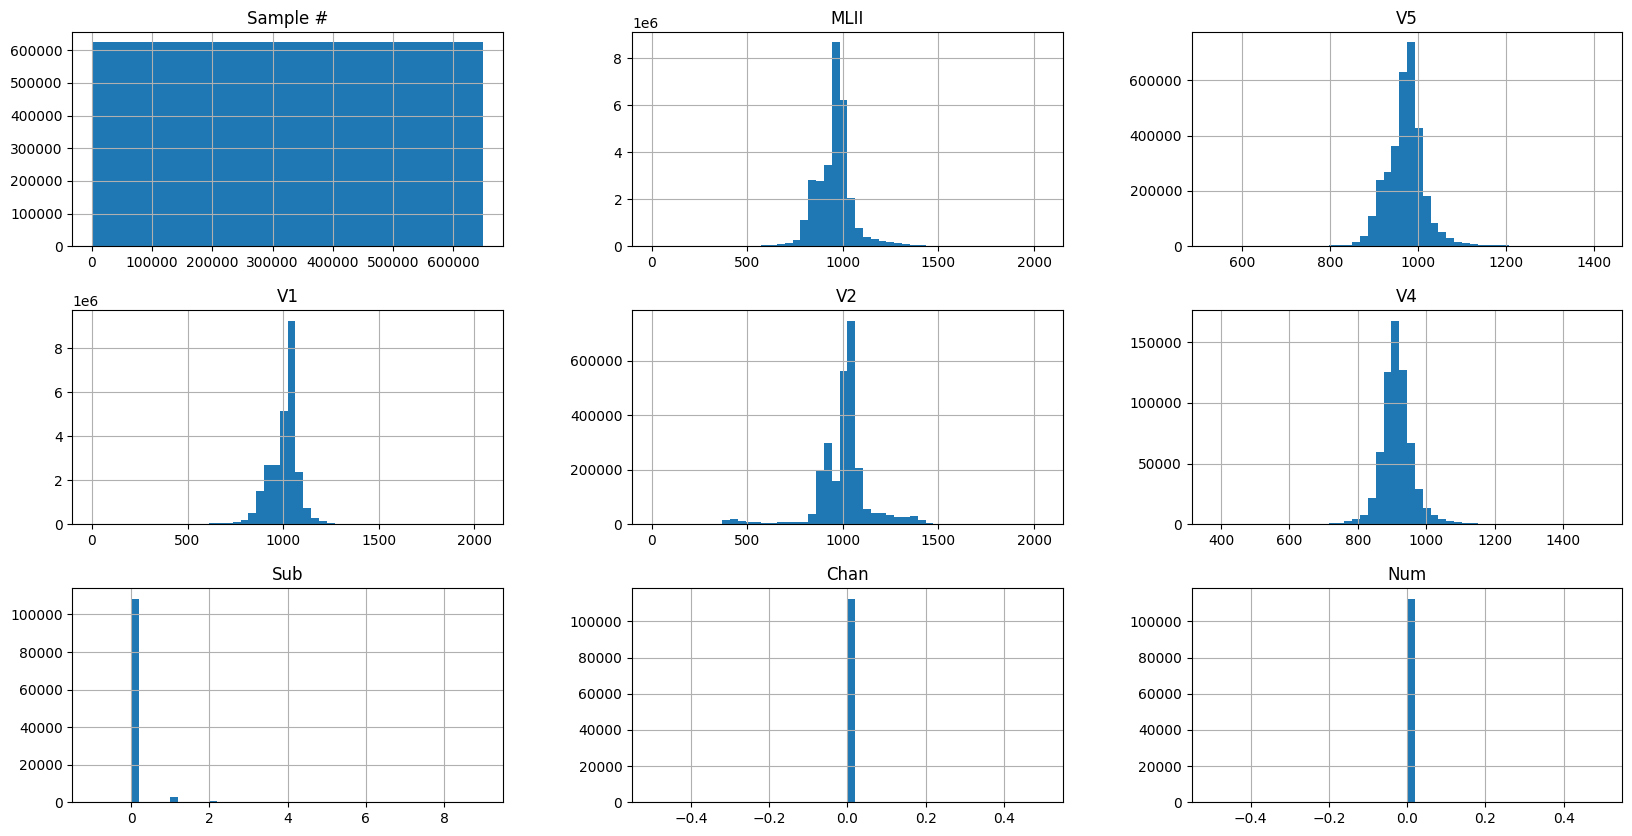

In [31]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x2310d9ec4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2310d9eca30>,
 'boxes': [<matplotlib.lines.Line2D at 0x2310d9ec250>],
 'medians': [<matplotlib.lines.Line2D at 0x2310d9ecf70>],
 'fliers': [<matplotlib.lines.Line2D at 0x2310d9ed210>],
 'means': []}

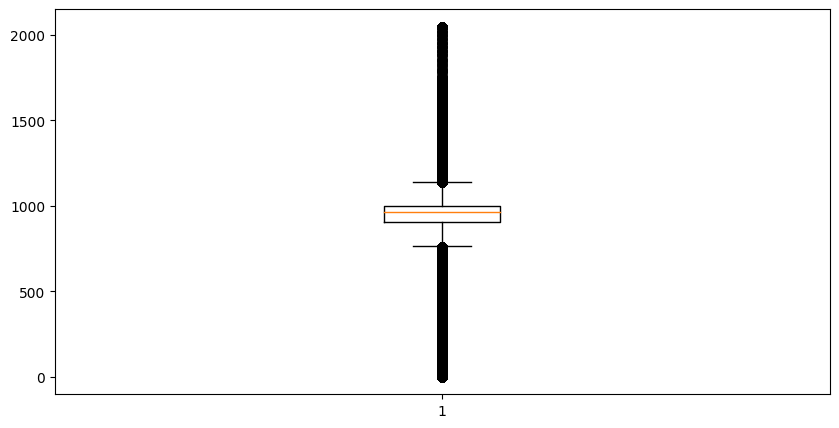

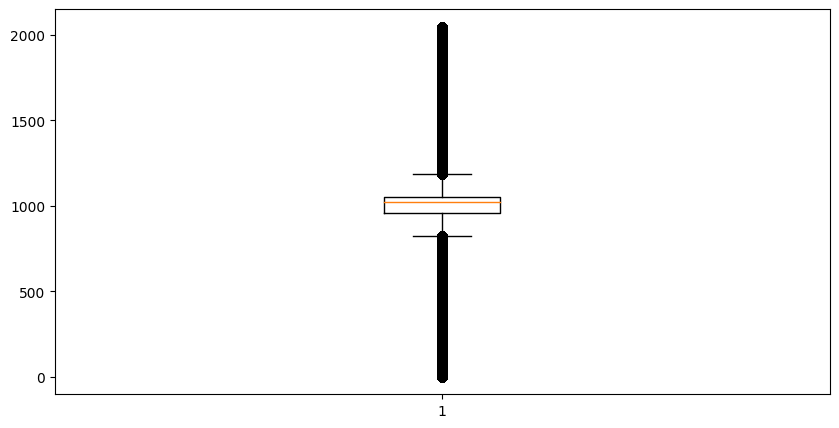

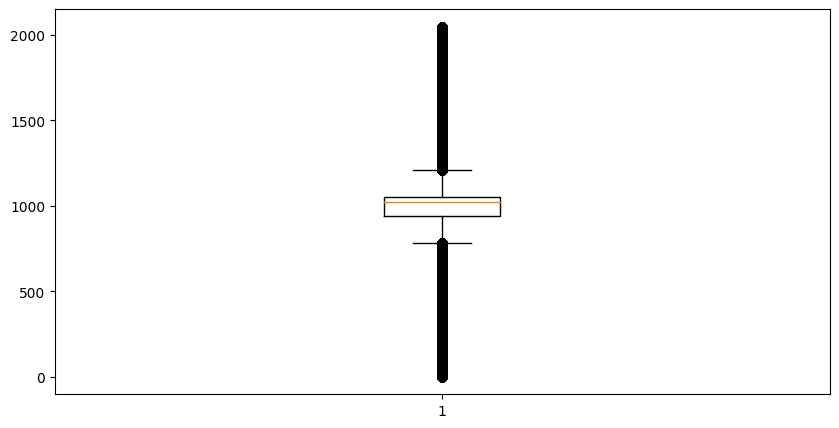

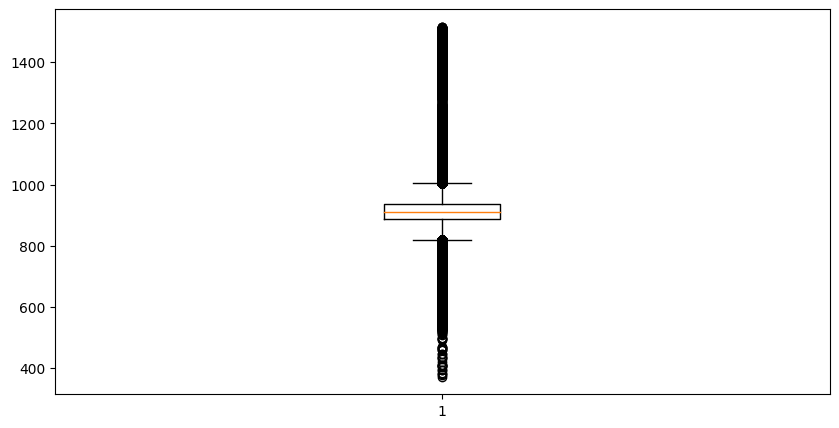

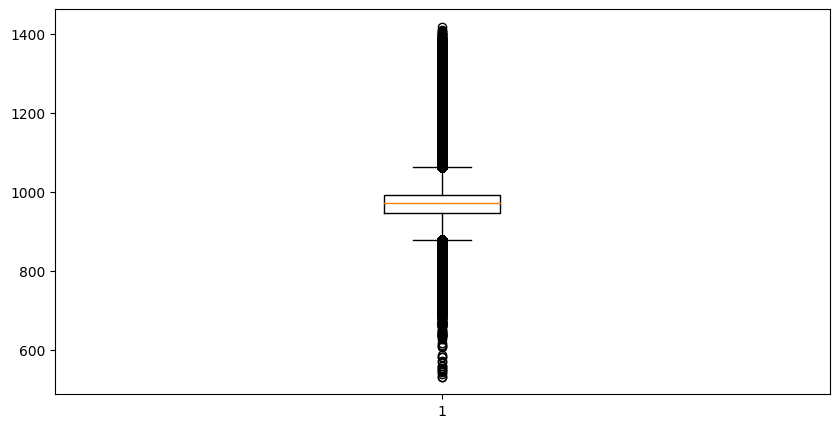

In [32]:
# Remove samples that are missing MLII to a temporary dataframe and make boxplot
df_temp = df[~df['MLII'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['MLII'])

# Remove samples that are missing V1 to a temporary dataframe and make boxplot
df_temp = df[~df['V1'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V1'])

# Remove samples that are missing V2 to a temporary dataframe and make boxplot
df_temp = df[~df['V2'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V2'])

# Remove samples that are missing V4 to a temporary dataframe and make boxplot
df_temp = df[~df['V4'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V4'])

# Remove samples that are missing V5 to a temporary dataframe and make boxplot
df_temp = df[~df['V5'].isnull()]
plt.figure(figsize=(10, 5))
plt.boxplot(df_temp['V5'])

In [33]:
# Scaling MLII, V1, V2, V4 and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V1 = df['V1'].to_numpy()
V2 = df['V2'].to_numpy()
V4 = df['V4'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V1'] = scaler.fit_transform(V1.reshape(-1, 1))
df['V2'] = scaler.fit_transform(V2.reshape(-1, 1))
df['V4'] = scaler.fit_transform(V4.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

In [34]:
# Filtering MLII, V1, V2, V4 and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V1'] = df['V1'].rolling(window=8, min_periods=1).mean()
df['V2'] = df['V2'].rolling(window=8, min_periods=1).mean()
df['V4'] = df['V4'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

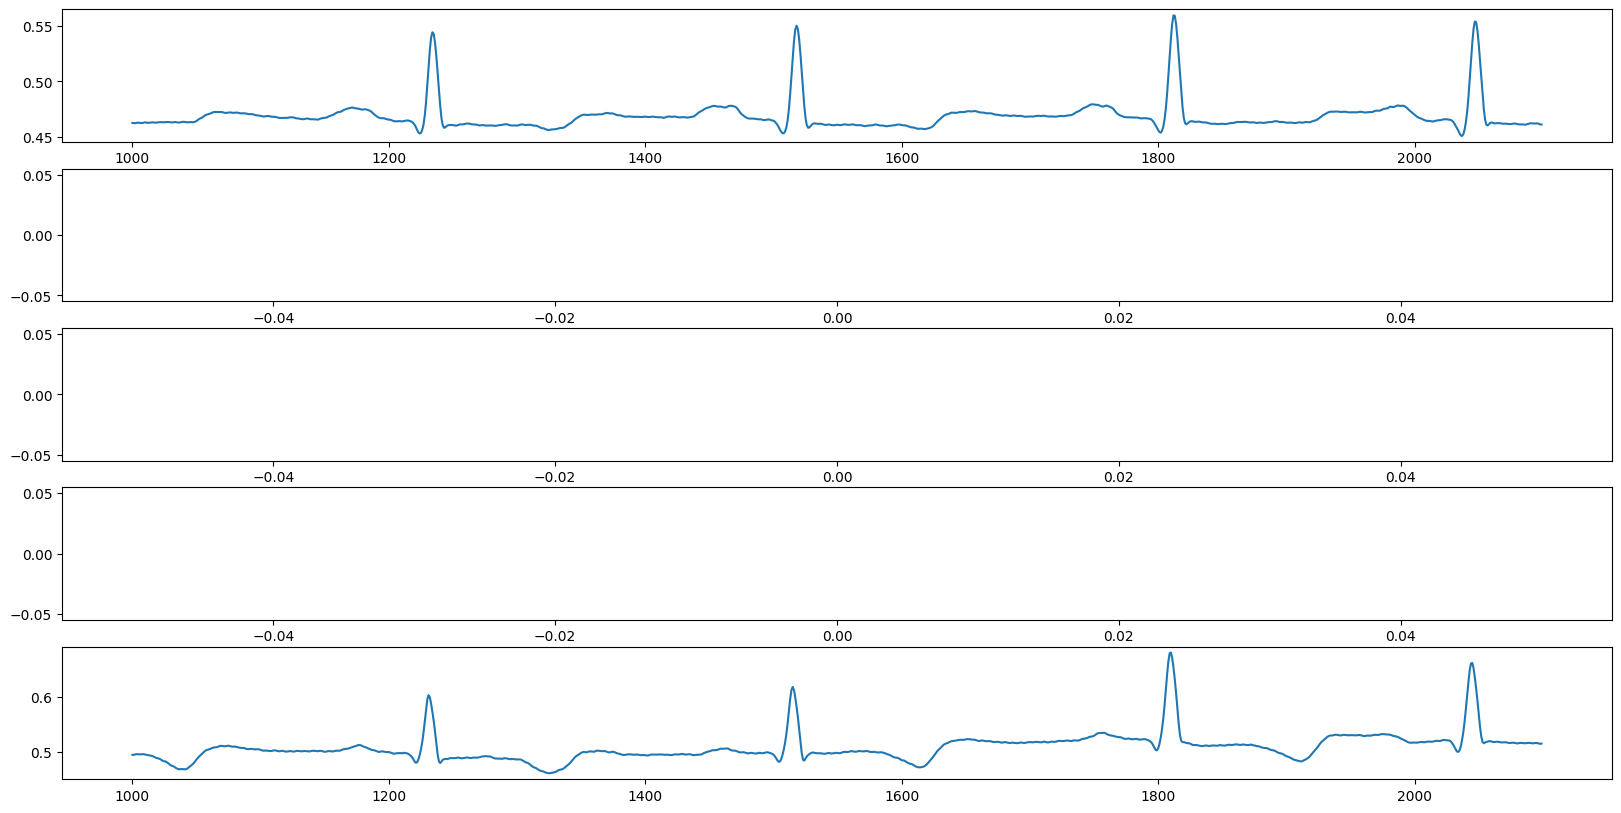

In [37]:
# Plot ecg examples with each feature in its subplot
plt.figure(figsize=(20, 10))
plt.subplot(511)
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.subplot(512)
plt.plot(df['Sample #'][1000:2100], df['V1'][1000:2100])
plt.subplot(513)
plt.plot(df['Sample #'][1000:2100], df['V2'][1000:2100])
plt.subplot(514)
plt.plot(df['Sample #'][1000:2100], df['V4'][1000:2100])
plt.subplot(515)
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])


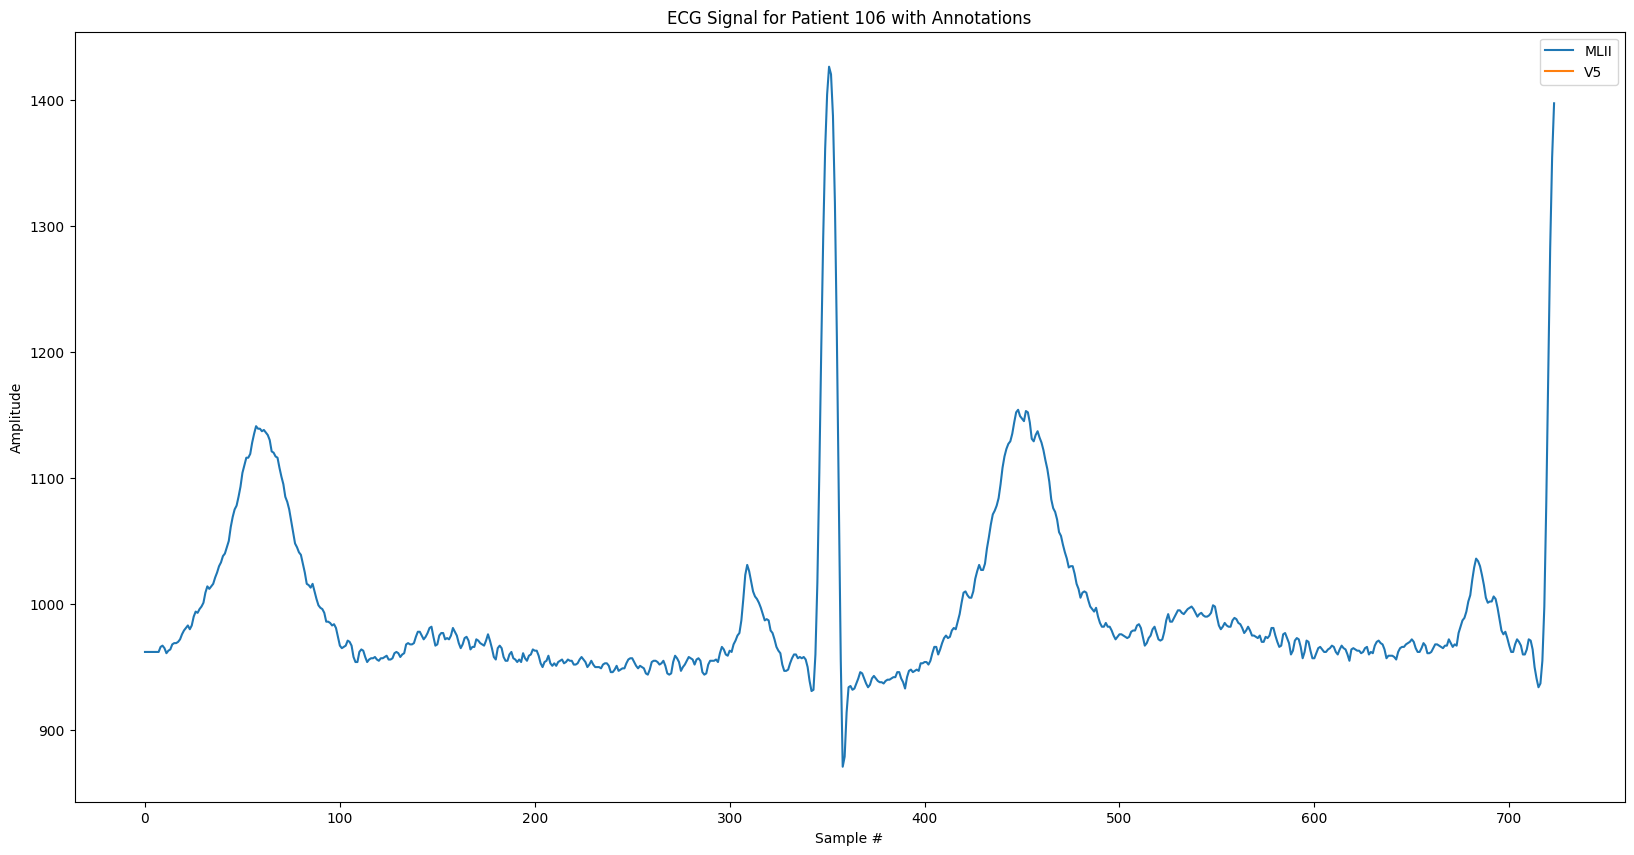

In [78]:
patient_id = 106
ecg_data = df[df['Patient'] == str(patient_id)]

sample_range = slice(0, 724)  # Adjust the slice as needed

plt.figure(figsize=(20, 10))
plt.plot(ecg_data['Sample #'][sample_range], ecg_data['MLII'][sample_range], label='MLII')
plt.plot(ecg_data['Sample #'][sample_range], ecg_data['V5'][sample_range], label='V5')
plt.xlabel('Sample #')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'ECG Signal for Patient {patient_id} with Annotations')
plt.show()

In [54]:
# Print entry 650001 from df
print(df.iloc[649999])

Sample #    649999
MLII         768.0
V5          1024.0
Patient        100
V1             NaN
V2             NaN
V4             NaN
Time           NaN
Type             N
Sub            NaN
Chan           NaN
Num            NaN
Aux            NaN
Name: 649999, dtype: object
